In [1]:
# Parameters
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
enhancers_metadata_path = "Analysis/enhancers/ensembl/ensembl_enhancers_metadata.txt"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
cell_idents_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"


In [2]:
#default params
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
enhancers_metadata_path = "Analysis/enhancers/tcea_FANTOM/tcea_FANTOM_enhancers_metadata.txt"
cell_idents_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"
rna_pca_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_pca.RDS"


# eRNA count matrix analysis

In [3]:
library(magrittr)
library(dplyr)
library(stringi)
library(ggplot2)
library(Matrix)
library(tibble)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
setwd(here::here()) # set working directory to project root
getwd()

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [5]:
rna_enhancers = readRDS(filtered_erna_path)

In [6]:
dim(rna_enhancers)

[1] 29683 11868

# Cell type specific enhancers filtering

In [7]:
# read enhancer per cell type files
library(stringi)
library(data.table)
enhancer_per_celltype= data.table::fread(cell_type_enhancers_path, header = F, data.table = FALSE, sep = "\t")


Attaching package: ‘data.table’




The following objects are masked from ‘package:dplyr’:

    between, first, last




In [8]:
colnames(enhancer_per_celltype) = c("enhancer_id", "cell_type")
head(enhancer_per_celltype)

,enhancer_id,cell_type
,<chr>,<chr>
1,ENSR1_9CZM,CD8+
2,ENSR1_9CZM,CD14+_monocyte
3,ENSR1_8PZK,CD8+
4,ENSR1_8PZK,CD14+_monocyte
5,ENSR1_8PZQ,CD8+
6,ENSR1_8PZQ,CD14+_monocyte


Warning message:
“Removed 1619 rows containing non-finite outside the scale range
(`stat_ydensity()`).”


Warning message:
“Removed 1619 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


Warning message:
“Removed 557 rows containing missing values or values outside the scale range
(`geom_violin()`).”


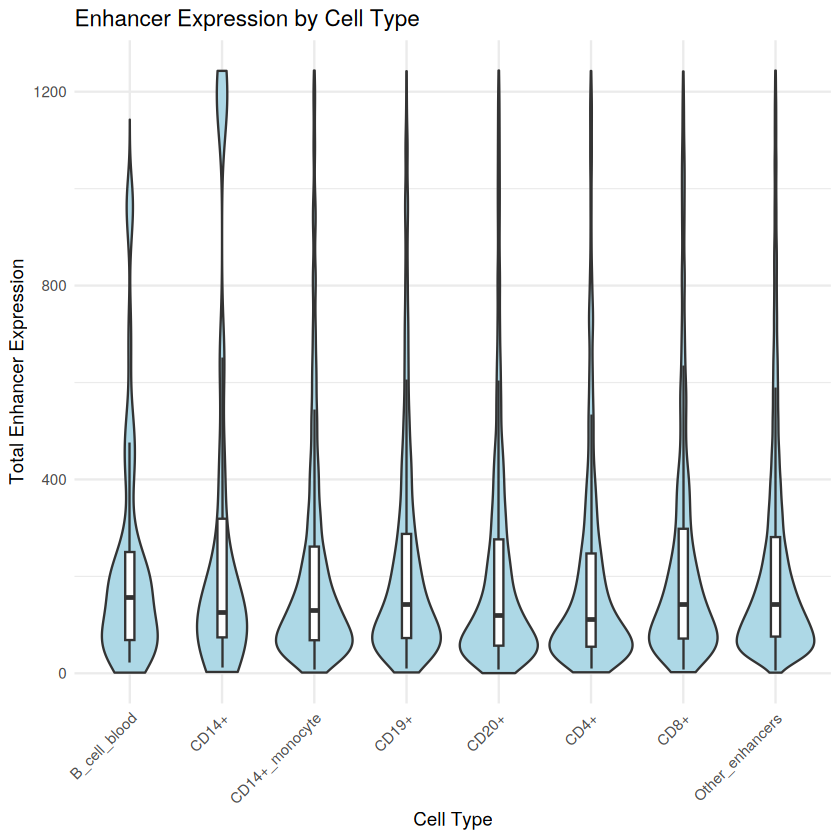

In [9]:
# per enhancer
rna_enhancers %>% rowSums() %>% as.data.frame() %>%
  rownames_to_column("enhancer_id") %>%
  left_join(enhancer_per_celltype, by = "enhancer_id") %>%
  mutate(cell_type = ifelse(is.na(cell_type), "Other_enhancers", cell_type)) %>%
  ggplot(aes(x = cell_type, y = `.`)) +
  geom_violin(trim = FALSE, fill = "lightblue") +
  geom_boxplot(width = 0.1, position = position_dodge(0.9), outlier.shape = NA) +
  labs(title = "Enhancer Expression by Cell Type",
       x = "Cell Type",
       y = "Total Enhancer Expression") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(0, quantile(rna_enhancers %>% rowSums(), 0.95)) # limit y-axis to 95th percentile to reduce effect of outliers

In [10]:
cell_idents = readRDS(cell_idents_path)
cell_idents = rownames_to_column(as.data.frame(cell_idents), var = "cell_id")
#remove "-1" suffix from cell_id
cell_idents$cell_id = stri_replace_last_fixed(cell_idents$cell_id, "-1", "")
colnames(cell_idents)[2] = "cell_type"

In [11]:
# find common cells between cell_idents and rna_enhancers
common_cells = intersect(cell_idents$cell_id, colnames(rna_enhancers))
length(common_cells)

[1] 10625

In [12]:
# filter both to common cells
cell_idents = cell_idents %>% filter(cell_id %in% common_cells)
rna_enhancers = rna_enhancers[,common_cells]

In [13]:
# heatmap of enhancer cell type expression by cell type with complex heatmap
library(ComplexHeatmap)
library(circlize)
# calculate average enhancer expression per cell type
enhancer_avg_expr = rna_enhancers %>% t() %>% as.matrix() %>%
  as.data.frame() %>%
  rownames_to_column("cell_id") %>%
  left_join(cell_idents, by = "cell_id") %>%
  select(-cell_id) %>%
  group_by(cell_type) %>%
  summarise(across(everything(), mean)) %>%
  column_to_rownames("cell_type") %>%
  t()

#average rows by enhancer cell type
enhancer_avg_expr = as.data.frame(enhancer_avg_expr) %>%
  rownames_to_column("enhancer_id") %>%
  left_join(enhancer_per_celltype, by = "enhancer_id") %>%
  mutate(cell_type = ifelse(is.na(cell_type), "Other_enhancers", cell_type)) %>%
  select(-enhancer_id) %>%
  group_by(cell_type) %>%
  summarise(across(where(is.numeric), mean)) %>%
  column_to_rownames("cell_type") %>% scale() %>%
  t()




Loading required package: grid



ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


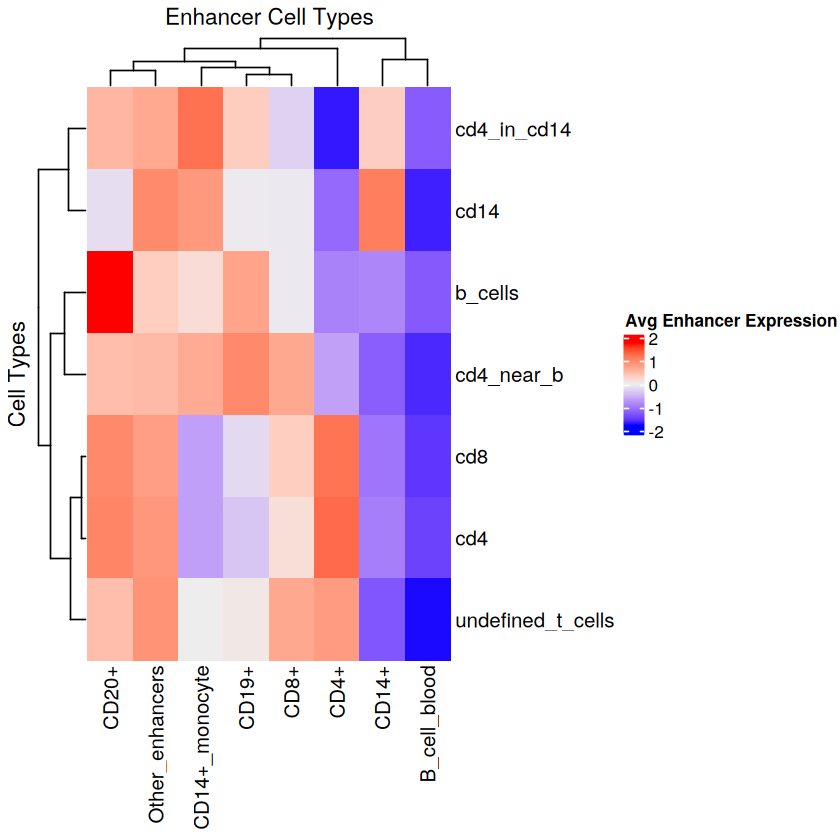

In [14]:
Heatmap(as.matrix(enhancer_avg_expr),
        name = "Avg Enhancer Expression",
        show_row_names = TRUE,
        show_column_names = TRUE,
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        row_title = "Cell Types",
        column_title = "Enhancer Cell Types")

# KNN Smoothing

library(FNN)      # Fast Nearest Neighbor search
library(Matrix)   # Required for sparse matrix operations

#' KNN Smoothing for Enhancer RNA Matrices
#' 
#' This function performs imputation on sparse eRNA data by averaging values 
#' from transcriptionally similar cells (neighbors identified in mRNA space).
#'
#' @param erna_norm A normalized eRNA matrix (Enhancers x Cells). 
#'                  Should be library-size normalized and log-transformed.
#' @param rna_pca   A PCA matrix of the mRNA data (Cells x PCs). 
#'                  Used to define the biological similarity between cells.
#' @param k         Number of neighbors to consider for smoothing. Default is 15.
#'
#' @return A smoothed eRNA matrix of the same dimensions as the input.
knn_smooth_erna <- function(erna_norm, rna_pca, k = 15) {
  
  # Check if dimensions match: PCA rows must equal eRNA columns (cells)
  if (nrow(rna_pca) != ncol(erna_norm)) {
    stop("Number of cells in PCA matrix does not match eRNA matrix columns.")
  }

  # Step 1: Find K-Nearest Neighbors in the mRNA PCA space
  # This ensures we smooth across cells that are biologically similar.
  cat("Calculating nearest neighbors...\n")
  knn_res <- get.knn(rna_pca, k = k)
  
  # Step 2: Build the Adjacency Matrix (Cells x Cells)
  # We create a sparse weighting matrix where each neighbor gets 1/k weight.
  n_cells <- nrow(rna_pca)
  row_idx <- rep(1:n_cells, each = k)
  col_idx <- as.vector(knn_res$nn.index) 
  
  # Create a sparse matrix for efficient computation
  adj <- sparseMatrix(
    i = row_idx, 
    j = col_idx, 
    x = 1/k, 
    dims = c(n_cells, n_cells)
  )
  
  # Step 3: Self-inclusion (Adding the cell's own data to the smoothing)
  # We ensure the cell's original signal is preserved in the average.
  diag(adj) <- 1/k 
  
  # Re-normalize rows to ensure weights sum to 1
  adj <- adj / rowSums(adj)
  
  # Step 4: Perform Matrix Multiplication
  # (Enhancers x Cells) %*% (Cells x Cells) = (Enhancers x Cells)
  # This step effectively replaces each cell's value with the weighted average of its neighbors.
  cat("Applying smoothing to eRNA matrix...\n")
  smoothed_erna <- erna_norm %*% adj
  
  return(as.matrix(smoothed_erna))
}

# --- Usage Example ---
# normalized_erna_log <- log1p(norm_counts) # Library-size normalized data
# pca_coords <- Embeddings(seurat_obj, "pca") # Cell embeddings from scRNA-seq
# smoothed_matrix <- knn_smooth_erna(normalized_erna_log, pca_coords, k = 20)

rna_pca = readRDS(rna_pca_path)
#remove "-1" suffix from rownames
rownames(rna_pca) = stri_replace_last_fixed(rownames(rna_pca), "-1", "")
pca_input <- rna_pca[, 1:15] # use first 10 PCs
common_cells = intersect(colnames(rna_enhancers), rownames(pca_input))
rna_enhancers = rna_enhancers[, common_cells]
pca_input = pca_input[common_cells, ]
normalized_erna_log <- log1p(rna_enhancers) # Library-size normalized data
smoothed_erna = knn_smooth_erna(normalized_erna_log, pca_input, k = 3)

colnames(smoothed_erna) <- colnames(normalized_erna_log)

# heatmap of enhancer cell type expression by cell type with complex heatmap
library(ComplexHeatmap)
library(circlize)
# calculate average enhancer expression per cell type
enhancer_avg_expr = smoothed_erna %>% t() %>% as.matrix() %>%
  as.data.frame() %>%
  rownames_to_column("cell_id") %>%
  left_join(cell_idents, by = "cell_id") %>%
  select(-cell_id) %>%
  group_by(cell_type) %>%
  summarise(across(everything(), mean)) %>%
  column_to_rownames("cell_type") %>%
  t()

#average rows by enhancer cell type
enhancer_avg_expr = as.data.frame(enhancer_avg_expr) %>%
  rownames_to_column("enhancer_id") %>%
  left_join(enhancer_per_celltype, by = "enhancer_id") %>%
  mutate(cell_type = ifelse(is.na(cell_type), "Other_enhancers", cell_type)) %>%
  select(-enhancer_id) %>%
  group_by(cell_type) %>%
  summarise(across(where(is.numeric), mean)) %>%
  column_to_rownames("cell_type") %>% scale() %>%
  t() 
 




Heatmap(as.matrix(enhancer_avg_expr),
        name = "Avg Enhancer Expression",
        show_row_names = TRUE,
        show_column_names = TRUE,
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        row_title = "Cell Types",
        column_title = "Enhancer Cell Types")

# correlation across cells, annotate by cell type

# pearson correlation across cells, annotate by cell type
rna_enhancers_df <- as.data.frame(as.matrix(t(rna_enhancers)))
cor_res = cor(rna_enhancers_df, method = "pearson")